<a href="https://colab.research.google.com/github/susmitmishra125/aerial-cactus-identification/blob/main/Aerial_cactus_indentification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 from google.colab import files

In [2]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"susmitkumarmishra","key":"e17d361475650e18eaf3582e5b2b8342"}'}

In [3]:
!mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
 ! chmod 600 ~/.kaggle/kaggle.json
#  !kaggle datasets list

In [6]:
!mkdir -p data
!kaggle competitions download -c aerial-cactus-identification -p data

  0% 0.00/160k [00:00<?, ?B/s]
100% 160k/160k [00:00<00:00, 50.7MB/s]
  0% 0.00/4.20M [00:00<?, ?B/s]
100% 4.20M/4.20M [00:00<00:00, 69.4MB/s]
  0% 0.00/19.2M [00:00<?, ?B/s]
100% 19.2M/19.2M [00:00<00:00, 177MB/s]
  0% 0.00/667k [00:00<?, ?B/s]
100% 667k/667k [00:00<00:00, 211MB/s]


In [ ]:
!unzip data/train.zip -d data
!unzip data/test.zip -d data

In [8]:
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt
import PIL
from sklearn.model_selection import train_test_split
from IPython.display import Image, display

In [9]:
train_csv = pd.read_csv('data/train.csv')
print(train_csv.describe())
print(train_csv.head())

         has_cactus
count  17500.000000
mean       0.750629
std        0.432662
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
                                     id  has_cactus
0  0004be2cfeaba1c0361d39e2b000257b.jpg           1
1  000c8a36845c0208e833c79c1bffedd1.jpg           1
2  000d1e9a533f62e55c289303b072733d.jpg           1
3  0011485b40695e9138e92d0b3fb55128.jpg           1
4  0014d7a11e90b62848904c1418fc8cf2.jpg           1


In [10]:
filenames = ['data/train/' + fname for fname in train_csv['id'].tolist()]
labels = train_csv['has_cactus'].tolist()

train_filenames, val_filenames, train_labels, val_labels = train_test_split(filenames,
                                                                            labels,
                                                                            train_size=0.9,
                                                                            random_state=420)

num_train = len(train_filenames)
num_val = len(val_filenames)

In [11]:
IMAGE_SIZE = 224


def _parse_fn(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string)
  image_normalized = (tf.cast(image_decoded, tf.float32)/127.5) - 1
  image_resized = tf.image.resize(image_normalized, (IMAGE_SIZE, IMAGE_SIZE))
  return image_resized, label

In [12]:
BATCH_SIZE = 32

train_data = tf.data.Dataset.from_tensor_slices((tf.constant(train_filenames), tf.constant(train_labels))).map(_parse_fn).shuffle(buffer_size=10000).batch(BATCH_SIZE)


val_data = tf.data.Dataset.from_tensor_slices((tf.constant(val_filenames), tf.constant(val_labels))).map(_parse_fn).batch(BATCH_SIZE)

In [13]:
# Base model with MobileNetV2
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')
base_model.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [14]:
maxpool_layer = tf.keras.layers.GlobalMaxPooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

In [15]:
learning_rate = 0.001

model = tf.keras.Sequential([
    base_model,
    maxpool_layer,
    prediction_layer
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d (Global (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [16]:
num_epochs = 30
steps_per_epoch = round(num_train)//BATCH_SIZE
val_steps = 20

In [17]:
history = model.fit(train_data.repeat(),
                    epochs=num_epochs,
                    steps_per_epoch = steps_per_epoch,
                    validation_data=val_data.repeat(), 
                    validation_steps=val_steps)

Epoch 1/30
492/492 [==============================] - 43s 55ms/step - loss: 0.3162 - accuracy: 0.8970 - val_loss: 0.1028 - val_accuracy: 0.9625
Epoch 2/30
492/492 [==============================] - 33s 67ms/step - loss: 0.0686 - accuracy: 0.9751 - val_loss: 0.1031 - val_accuracy: 0.9688
Epoch 3/30
492/492 [==============================] - 33s 66ms/step - loss: 0.0544 - accuracy: 0.9809 - val_loss: 0.0797 - val_accuracy: 0.9703
Epoch 4/30
492/492 [==============================] - 33s 67ms/step - loss: 0.0411 - accuracy: 0.9848 - val_loss: 0.0744 - val_accuracy: 0.9750
Epoch 5/30
492/492 [==============================] - 33s 67ms/step - loss: 0.0418 - accuracy: 0.9844 - val_loss: 0.0718 - val_accuracy: 0.9719
Epoch 6/30
492/492 [==============================] - 33s 67ms/step - loss: 0.0362 - accuracy: 0.9856 - val_loss: 0.0737 - val_accuracy: 0.9797
Epoch 7/30
492/492 [==============================] - 33s 68ms/step - loss: 0.0329 - accuracy: 0.9873 - val_loss: 0.0590 - val_accuracy:

In [18]:
model.save_weights('weights_epoch_30.h5')

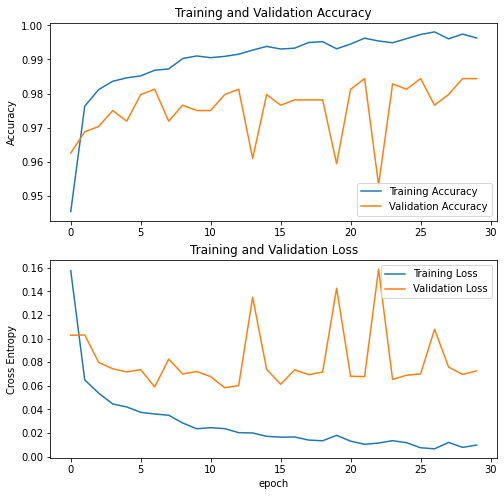

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
def _parse_fn_test(filename):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string)
  image_normalized = (tf.cast(image_decoded, tf.float32)/127.5) - 1
  image_resized = tf.image.resize(image_normalized, (IMAGE_SIZE, IMAGE_SIZE))
  return image_resized

In [21]:
test_filenames=['data/test/'+  fname for fname in os.listdir('data/test')]
test_data = tf.data.Dataset.from_tensor_slices(
  (tf.constant(test_filenames))
)
test_data=(test_data.map(_parse_fn_test).batch((BATCH_SIZE)))
pred=model.predict(test_data)

In [22]:
df=pd.DataFrame(test_filenames,columns=['id'])
df['id']=df['id'].apply(lambda x : x.split('/')[-1])
df['has_cactus']=pred
df.to_csv('submission.csv',index=False)
# !kaggle competitions submit aerial-cactus-identification -f submission.csv -m "My submission"

In [23]:
# from google.colab import files
# files.download('submission.csv')
files.upload()

Saving index.jpg to index.jpg


{'index.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\t\x06\x07\x12\x10\x10\x15\x10\x12\x12\x15\x15\x15\x15\x15\x17\x15\x15\x15\x15\x15\x15\x15\x17\x15\x17\x15\x17\x17\x17\x15\x15\x15\x15\x18\x1d( \x18\x1a%\x1d\x16\x15"1!%)-...\x17\x1f383-7(-.+\x01\n\n\n\x0e\r\x0e\x1b\x10\x10\x1b-& %-5---------5--------------------------------------\xff\xc0\x00\x11\x08\x01\x13\x00\xb7\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x00\x02\x02\x03\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x05\x07\x03\x04\x06\x02\xff\xc4\x00B\x10\x00\x01\x03\x01\x04\x07\x05\x04\x07\x07\x03\x05\x00\x00\x00\x00\x01\x00\x02\x11\x03\x04\x12!1\x05\x06AQaq\x81\x13"\x91\xa1\xb1\x072R\xc1\x14#Bb\x92\xd1\xf0$crs\xb2\xe1\xf13S\x82\x15%\xa2\xb3\xe2\xff\xc4\x00\x19\x01\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x02\x01\x04\x05\xff\xc4\x00%\x11\x01\x00\x02\x02\x02\x02\x01\x03\x05\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x11!12A\

In [25]:
files.upload()

Saving index (1).jpg to index (1).jpg


{'index (1).jpg': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xf4\x00\x00\x01M\x08\x02\x00\x00\x00yq\n`\x00\x00\n1iCCPICC Profile\x00\x00x\x9c\x9d\x96wTS\xd9\x16\x87\xcf\xbd7\xbdP\x92\x10\x8a\x94\xd0khR\x02H\r\xbdH\x91.*1\t\x10J\xc0\x90\x00"6DTpDQ\x91\xa6\x082(\xe0\x80\xa3C\x91\xb1"\x8a\x85\x01Q\xb1\xeb\x04\x19D\xd4qp\x14\x1b\x96Id\xad\x19\xdf\xbcy\xef\xcd\x9b\xdf\x1f\xf7~k\x9f\xbd\xcf\xddg\xef}\xd6\xba\x00\x90\xfc\x83\x05\xc2LX\t\x80\x0c\xa1X\x14\xe1\xe7\xc5\x88\x8d\x8bg`\x07\x01\x0c\xf0\x00\x03l\x00\xe0p\xb3\xb3B\x16\xf8F\x02\x99\x02|\xd8\x8cl\x99\x13\xf8\x17\xbd\xba\x0e \xf9\xfb*\xd3?\x8c\xc1\x00\xff\x9f\x94\xb9Y"1\x00P\x98\x8c\xe7\xf2\xf8\xd9\\\x19\x17\xc98=W\x9c%\xb7O\xc9\x98\xb64M\xce0J\xce"Y\x822V\x93s\xf2,[|\xf6\x99e\x0f9\xf32\x84<\x19\xcbs\xce\xe2e\xf0\xe4\xdc\'\xe3\x8d9\x12\xbe\x8c\x91`\x19\x17\xe7\x08\xf8\xb92\xbe&c\x83tI\x86@\xc6o\xe4\xb1\x19|N6\x00(\x92\xdc.\xe6sSdl-c\x92(2\x82-\xe3y\x00\xe0H\xc9_\xf0\xd2/X\xcc\xcf\x13\xcb\x0f\xc5\xce\xccZ.\x12$\xa7\x88\x19&\\S\x86\x

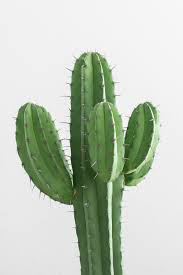

In [26]:
PIL.Image.open('index.jpg')# image of a cactus 

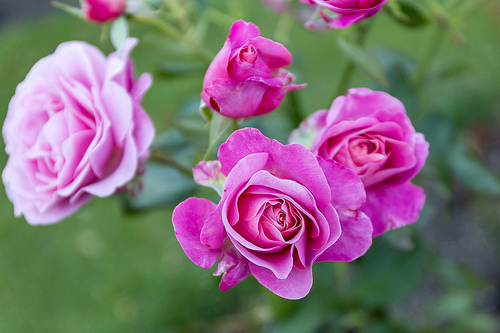

In [27]:
PIL.Image.open('index (1).jpg')#image of a non cactus

In [28]:
example_data=tf.data.Dataset.from_tensor_slices(tf.constant(['index.jpg','index (1).jpg']))
example_data=(example_data.map(_parse_fn_test).batch((BATCH_SIZE)))
pred=model.predict(example_data)

In [29]:
print("The probability that the first image is a cactus is",pred[0][0])
print("The probability that the second image is a cactus is",pred[1][0])

The probability that the first image is a cactus is 1.0
The probability that the first image is a cactus is 4.6184562e-10
